In [ ]:
!pip install -q transformers datasets accelerate sentencepiece


In [ ]:
import os
import math
import torch
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    set_seed,
)

### Important Notes:

USE_SAMPLE_DATA = False -> This means we are using the entire processed_data

USE_SAMPLE_DATA = True -> This means we are using the sample of processed_data which is only 10 rows


MAX_LENGTH = 512 -> This is the max token length, can tune it to make it better but take a lot longer


In [ ]:
# CONFIG (CHANGE HERE)

# First run: use the tiny sample_data.csv for fast debugging
USE_SAMPLE_DATA = True         # <-- False runs entire dataset (processed_data.csv),
                                # True runs small dataset (sample_data.csv)
# USE_SAMPLE_DATA = False

BASE_MODEL_NAME = "gpt2"       # instead of "distilgpt2"
MAX_LENGTH = 512               # 384 at most if you want extra slack
#USE_SAMPLE_DATA = False        # full processed_data.csv

# Random seed (67 for the memes lolllz)
set_seed(67)

# Colab device (GPU if available)
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

Before running below, make sure to have the processed_data drive in your "MyDrive" else this will fail unless you wanna change it to where you have the data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

print("Top level:")
!ls /content/drive

print("\nMyDrive contents:")
!ls "/content/drive/MyDrive"

BASE_DIR = "/content/drive/MyDrive/processed data"

print("\n\nBASE_DIR:", BASE_DIR)
print("\n\nFiles inside BASE_DIR:")
print(os.listdir(BASE_DIR))



Mounted at /content/drive
Top level:
MyDrive  Shareddrives

MyDrive contents:
'605 Project.ipynb'		  MSML_612_Assigment_4_Nikhil_Roy.ipynb
 AirlineDelayPrediction		  MSML_612_Assignment3_Nikhil_Roy.ipynb
'Colab Notebooks'		  MSML640_FinalProject_Phase2.docx
'Copy of Homework 1.gdoc'	 'MSML 640 Github Code Link.gdoc'
'Copy of Homework 3.gdoc'	 'MSML 640 Github Code Link.pdf'
'Final Exam Coding (1st Block)'  'processed data'
'MSML 603 Homework Projects'	  Untitled0.ipynb


BASE_DIR: /content/drive/MyDrive/processed data


Files inside BASE_DIR:
['metadata.json', 'sample_data.csv', 'images', 'reports', 'processed_data.csv']


Loading in data...

In [ ]:
csv_name = "sample_data.csv" if USE_SAMPLE_DATA else "processed_data.csv"
csv_path = os.path.join(BASE_DIR, csv_name)

df = pd.read_csv(csv_path)
print("Using CSV:", csv_path)
print("Columns:", df.columns.tolist())
print("Total rows:", len(df))
df.head()


Using CSV: /content/drive/MyDrive/processed data/sample_data.csv
Columns: ['uid', 'filename', 'projection', 'findings_final', 'impression_final', 'split']
Total rows: 10


,uid,filename,projection,findings_final,impression_final,split
0,1,1_IM-0001-4001.dcm.png,Frontal,The cardiac silhouette and mediastinum size ar...,Normal chest x-.,train
1,1,1_IM-0001-3001.dcm.png,Lateral,The cardiac silhouette and mediastinum size ar...,Normal chest x-.,train
2,2,2_IM-0652-1001.dcm.png,Frontal,Borderline cardiomegaly. Midline sternotomy . ...,No acute pulmonary findings.,test
3,2,2_IM-0652-2001.dcm.png,Lateral,Borderline cardiomegaly. Midline sternotomy . ...,No acute pulmonary findings.,test
4,3,3_IM-1384-1001.dcm.png,Frontal,normal,"No displaced rib fractures, pneumothorax, or p...",train


from above, we can see that we have 2 seperate images/views from each patient or uid in this case: one perspective is in the frontal lobe and the other persepctive is the lateral lobe... cool!!

Below, we are adding a column called "report_text" which combines the findings_final column with the impression_final column to have it as one text

In [ ]:
# Make sure text columns have no NaNs
for col in ["findings_final", "impression_final"]:
    if col in df.columns:
        df[col] = df[col].fillna("")

# Create structured clinical report text
df["report_text"] = (
    "<FINDINGS> " + df["findings_final"].fillna("").astype(str) +
    " <IMPRESSION> " + df["impression_final"].fillna("").astype(str)
)

df[["findings_final", "impression_final", "report_text"]].head()


,findings_final,impression_final,report_text
0,The cardiac silhouette and mediastinum size ar...,Normal chest x-.,<FINDINGS> The cardiac silhouette and mediasti...
1,The cardiac silhouette and mediastinum size ar...,Normal chest x-.,<FINDINGS> The cardiac silhouette and mediasti...
2,Borderline cardiomegaly. Midline sternotomy . ...,No acute pulmonary findings.,<FINDINGS> Borderline cardiomegaly. Midline st...
3,Borderline cardiomegaly. Midline sternotomy . ...,No acute pulmonary findings.,<FINDINGS> Borderline cardiomegaly. Midline st...
4,normal,"No displaced rib fractures, pneumothorax, or p...",<FINDINGS> normal <IMPRESSION> No displaced ri...


Train/val/test split using split column

In [ ]:
assert "split" in df.columns, "Expected a 'split' column with train/val/test labels."

train_df = df[df["split"] == "train"].copy()
val_df   = df[df["split"] == "val"].copy()
test_df  = df[df["split"] == "test"].copy()

print("Full sizes -> train/val/test:", len(train_df), len(val_df), len(test_df))

# For sample_data.csv this is already tiny, but we keep it generic.
DEBUG_MAX_TRAIN = 500
DEBUG_MAX_VAL   = 100
DEBUG_MAX_TEST  = 100

if USE_SAMPLE_DATA:
    train_df = train_df.sample(
        n=min(DEBUG_MAX_TRAIN, len(train_df)), random_state=42
    )
    val_df = val_df.sample(
        n=min(DEBUG_MAX_VAL, len(val_df)), random_state=42
    )
    test_df = test_df.sample(
        n=min(DEBUG_MAX_TEST, len(test_df)), random_state=42
    )

print("Using sizes -> train/val/test:", len(train_df), len(val_df), len(test_df))

test_df.head(2)
val_df.head(2)
train_df.head()



Full sizes -> train/val/test: 4 2 4
Using sizes -> train/val/test: 4 2 4


,uid,filename,projection,findings_final,impression_final,split,report_text
1,1,1_IM-0001-3001.dcm.png,Lateral,The cardiac silhouette and mediastinum size ar...,Normal chest x-.,train,<FINDINGS> The cardiac silhouette and mediasti...
5,3,3_IM-1384-2001.dcm.png,Lateral,normal,"No displaced rib fractures, pneumothorax, or p...",train,<FINDINGS> normal <IMPRESSION> No displaced ri...
0,1,1_IM-0001-4001.dcm.png,Frontal,The cardiac silhouette and mediastinum size ar...,Normal chest x-.,train,<FINDINGS> The cardiac silhouette and mediasti...
4,3,3_IM-1384-1001.dcm.png,Frontal,normal,"No displaced rib fractures, pneumothorax, or p...",train,<FINDINGS> normal <IMPRESSION> No displaced ri...


Prep for Hugging Face Datasets

In [ ]:
train_ds = Dataset.from_pandas(train_df[["report_text"]])
val_ds   = Dataset.from_pandas(val_df[["report_text"]])
test_ds  = Dataset.from_pandas(test_df[["report_text"]])

raw_datasets = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})

raw_datasets


DatasetDict({
    train: Dataset({
        features: ['report_text', '__index_level_0__'],
        num_rows: 4
    })
    validation: Dataset({
        features: ['report_text', '__index_level_0__'],
        num_rows: 2
    })
    test: Dataset({
        features: ['report_text', '__index_level_0__'],
        num_rows: 4
    })
})

Tokenizer with BOS/EOS + medical vocabulary - This ensures your vocab includes medical terms and section markers.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_NAME)

special_tokens = {
    "bos_token": "<BOS>",
    "eos_token": "<EOS>",
    "pad_token": "<PAD>",
    "additional_special_tokens": [
        "<FINDINGS>",
        "<IMPRESSION>",
    ],
}

num_added = tokenizer.add_special_tokens(special_tokens)
print("Added special tokens:", num_added)
print("Special tokens map:", tokenizer.special_tokens_map)

# Extra chest X-ray medical tokens
medical_tokens = [
    "cardiomegaly",
    "atelectasis",
    "pleural_effusion",
    "pneumothorax",
    "consolidation",
    "infiltrate",
    "interstitial",
    "opacity",
    "hyperinflation",
    "pneumonia",
    "pulmonary_edema",
    "mediastinal_widening",
    "rib_fracture",
    "tracheal_deviation",
]

num_med_added = tokenizer.add_tokens(medical_tokens)
print("Added medical tokens:", num_med_added)
print("New vocab size:", len(tokenizer))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Added special tokens: 5
Special tokens map: {'bos_token': '<BOS>', 'eos_token': '<EOS>', 'unk_token': '<|endoftext|>', 'pad_token': '<PAD>', 'additional_special_tokens': ['<FINDINGS>', '<IMPRESSION>']}
Added medical tokens: 14
New vocab size: 50275


Load GPT2 Decoder

In [ ]:
model = AutoModelForCausalLM.from_pretrained(BASE_MODEL_NAME)

# Resize token embeddings to match new tokenizer size
model.resize_token_embeddings(len(tokenizer))

# Configure BOS/EOS/PAD ids
model.config.bos_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

print("bos_token_id:", model.config.bos_token_id)
print("eos_token_id:", model.config.eos_token_id)
print("pad_token_id:", model.config.pad_token_id)

model.to(device)
device


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


bos_token_id: 50257
eos_token_id: 50258
pad_token_id: 50259


'cuda'

Making so decoder “starts with BOS” and “stops at EOS

In [ ]:
def preprocess_function(examples):
    texts = [
        tokenizer.bos_token + " " + t + " " + tokenizer.eos_token
        for t in examples["report_text"]
    ]
    return tokenizer(
        texts,
        max_length=MAX_LENGTH,
        truncation=True,
        padding=False,   # we'll pad dynamically in the collator
    )

tokenized_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

tokenized_datasets


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 4
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 2
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 4
    })
})

Data collator and training arguments

In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,   # causal LM, predicts next token
)

OUTPUT_ROOT = os.path.join(
    BASE_DIR,
    "decoder_pretrained_small" if USE_SAMPLE_DATA else "decoder_pretrained_full"
)

if USE_SAMPLE_DATA:
  training_args = TrainingArguments(
      output_dir=OUTPUT_ROOT,
      per_device_train_batch_size=2,
      per_device_eval_batch_size=2,
      gradient_accumulation_steps=4,   # effective batch size ~8
      num_train_epochs = 3,
      learning_rate=5e-5,
      warmup_steps=50,
      weight_decay=0.01,
      logging_steps=1,                 # <--- log every step so we see losses
      #evaluation_strategy="epoch",   # Uncomment if Zaratan works, but my local doesn't
      fp16=True if device == "cuda" else False,
  )
else:
    training_args = TrainingArguments(
      output_dir=OUTPUT_ROOT,
      per_device_train_batch_size=4,
      per_device_eval_batch_size=4,
      gradient_accumulation_steps=4,   # effective batch size ~8
      num_train_epochs = 6,             # Can increase to 8 if model has bad performance or more space on Zartan
      learning_rate=2e-5,
      warmup_steps=500,
      weight_decay=0.01,
      logging_steps=50,                 # <--- log every step so we see losses
      #evaluation_strategy="epoch",   # Uncomment if Zaratan works, but my local doesn't
      fp16=True if device == "cuda" else False,
    )


training_args


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.NO,
eval_use_gather_object=False,
f

API Key: 956dbe98d7f53808319630727d651a7fb45cff16

In [ ]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
)

train_result = trainer.train()
print(train_result)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nir64 (nir64-university-of-maryland) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
1,5.646800
2,5.507600
3,5.609400


TrainOutput(global_step=3, training_loss=5.5879225730896, metrics={'train_runtime': 41.4046, 'train_samples_per_second': 0.29, 'train_steps_per_second': 0.072, 'total_flos': 349069824000.0, 'train_loss': 5.5879225730896, 'epoch': 3.0})


Evaluation:

In [ ]:
# Regular eval + overall perplexity for the final checkpoint
eval_results = trainer.evaluate()
print(eval_results)

if "eval_loss" in eval_results:
    overall_perplexity = math.exp(eval_results["eval_loss"])
    print("Validation Perplexity (overall):", overall_perplexity)
else:
    print("No eval_loss found.")

# --- Per-epoch train/eval loss + val perplexity table ---

from collections import defaultdict

epoch_train_losses = defaultdict(list)
epoch_eval_losses = defaultdict(list)
epoch_eval_ppls   = defaultdict(list)

for entry in trainer.state.log_history:
    # Training loss entries (during training)
    if "loss" in entry and "epoch" in entry and "eval_loss" not in entry:
        epoch_train_losses[entry["epoch"]].append(entry["loss"])
    # Evaluation loss entries (when eval is run)
    if "eval_loss" in entry and "epoch" in entry:
        epoch_eval_losses[entry["epoch"]].append(entry["eval_loss"])
        try:
            epoch_eval_ppls[entry["epoch"]].append(math.exp(entry["eval_loss"]))
        except OverflowError:
            epoch_eval_ppls[entry["epoch"]].append(float("inf"))

print("\nEpoch | Train loss | Eval loss | Val Perplexity")
print("------|-----------|-----------|----------------")

all_epochs = sorted(set(list(epoch_train_losses.keys()) + list(epoch_eval_losses.keys())))
for ep in all_epochs:
    train_loss = epoch_train_losses[ep][-1] if ep in epoch_train_losses else None
    eval_loss  = epoch_eval_losses[ep][-1] if ep in epoch_eval_losses else None
    val_ppl    = epoch_eval_ppls[ep][-1]   if ep in epoch_eval_ppls   else None

    t_str = f"{train_loss:.4f}" if train_loss is not None else "   -   "
    e_str = f"{eval_loss:.4f}"  if eval_loss  is not None else "   -   "
    p_str = f"{val_ppl:.2f}"    if val_ppl    is not None else "   -   "

    print(f"{ep:5.1f} | {t_str:9} | {e_str:9} | {p_str:14}")


{'eval_loss': 4.0982866287231445, 'eval_runtime': 0.0423, 'eval_samples_per_second': 47.312, 'eval_steps_per_second': 23.656, 'epoch': 3.0}
Validation Perplexity (overall): 60.23699079990852

Epoch | Train loss | Eval loss | Val Perplexity
------|-----------|-----------|----------------
  1.0 | 5.6468    |    -      |    -          
  2.0 | 5.5076    |    -      |    -          
  3.0 | 5.6094    | 4.0983    | 60.24         


Saving:

decoder_tokenizer/

decoder_pretrained/

inside the processed data folder.

In [ ]:
#Naming it sample if we marked it earlier in cell 2, else we know it's on the entire dataset

if USE_SAMPLE_DATA:
  DECODER_TOKENIZER_DIR = os.path.join(BASE_DIR, "sample_decoder_tokenizer")
  DECODER_PRETRAINED_DIR = os.path.join(BASE_DIR, "sample_decoder_pretrained")
else:
  DECODER_TOKENIZER_DIR = os.path.join(BASE_DIR, "decoder_tokenizer")
  DECODER_PRETRAINED_DIR = os.path.join(BASE_DIR, "decoder_pretrained")

os.makedirs(DECODER_TOKENIZER_DIR, exist_ok=True)
os.makedirs(DECODER_PRETRAINED_DIR, exist_ok=True)

tokenizer.save_pretrained(DECODER_TOKENIZER_DIR)
model.save_pretrained(DECODER_PRETRAINED_DIR)

print("Saved tokenizer to:", DECODER_TOKENIZER_DIR)
print("Saved model to:", DECODER_PRETRAINED_DIR)


Saved tokenizer to: /content/drive/MyDrive/processed data/sample_decoder_tokenizer
Saved model to: /content/drive/MyDrive/processed data/sample_decoder_pretrained


Below, confirmation before I quit and sleep

This confirms the decoder:

starts with BOS

predicts next tokens

stops at EOS

In [ ]:

# Reload from whichever dirs we saved to in Cell 14
if USE_SAMPLE_DATA:
    LOAD_TOKENIZER_DIR = os.path.join(BASE_DIR, "sample_decoder_tokenizer")
    LOAD_MODEL_DIR     = os.path.join(BASE_DIR, "sample_decoder_pretrained")
else:
    LOAD_TOKENIZER_DIR = os.path.join(BASE_DIR, "decoder_tokenizer")
    LOAD_MODEL_DIR     = os.path.join(BASE_DIR, "decoder_pretrained")

print("Loading tokenizer from:", LOAD_TOKENIZER_DIR)
print("Loading model from:", LOAD_MODEL_DIR)

gen_tokenizer = AutoTokenizer.from_pretrained(LOAD_TOKENIZER_DIR)
gen_model = AutoModelForCausalLM.from_pretrained(LOAD_MODEL_DIR).to(device)

def generate_report(prompt="Findings:"):
    # Input begins with BOS + prompt
    input_text = gen_tokenizer.bos_token + " " + prompt
    input_ids = gen_tokenizer(input_text, return_tensors="pt").input_ids.to(device)

    output_ids = gen_model.generate(
        input_ids,
        max_length=256,
        num_beams=4,
        early_stopping=True,
        eos_token_id=gen_tokenizer.eos_token_id,
        pad_token_id=gen_tokenizer.pad_token_id,
        no_repeat_ngram_size=3,
    )

    raw = gen_tokenizer.decode(output_ids[0], skip_special_tokens=False)
    return raw

def pretty_print_report(prompt="Findings:"):
    raw = generate_report(prompt)
    cleaned = raw.replace(gen_tokenizer.bos_token, "").replace(gen_tokenizer.eos_token, "")
    print("PROMPT:", prompt)
    print("RAW OUTPUT (with BOS/EOS):", raw)
    print("\nCLEANED REPORT:\n", cleaned.strip(), "\n")
    print("-" * 80)

# Always generate a few samples, whether we're on sample_data or full dataset
pretty_print_report("Findings:")
pretty_print_report("Findings: The heart size is")
pretty_print_report("Impression:")


Loading tokenizer from: /content/drive/MyDrive/processed data/sample_decoder_tokenizer
Loading model from: /content/drive/MyDrive/processed data/sample_decoder_pretrained
PROMPT: Findings:
RAW OUTPUT (with BOS/EOS): <BOS> Findings:

In the present study, we investigated the effect of a high-fat, high-carbohydrate, low-fat diet on body composition in overweight and obese men and women. We found that a high fat, high carbohydrate, low fat diet significantly reduced body weight and body mass index (BMI) in men, but not in women. In contrast, a low fat, low carbohydrate, high fat diet did not significantly reduce body weight or BMI in overweight or obese men or women.

Methods

Participants

This study was approved by the Institutional Review Board of the University of California, San Francisco, and was conducted in accordance with the Declaration of Helsinki. The participants were recruited from the National Health and Nutrition Examination Survey (NHANES III) and the National Longitudina

### Loss Curves to visualize our basic performance:

Validation Perplexity (overall): 60.23699079990852

Epoch | Train loss | Eval loss | Val Perplexity
------|-----------|-----------|----------------
  1.0 | 5.6468    |    -      |    -          
  2.0 | 5.5076    |    -      |    -          
  3.0 | 5.6094    | 4.0983    | 60.24         

Epoch summary DataFrame:


,epoch,train_loss,eval_loss,val_perplexity
0,1.0,5.6468,NaN,NaN
1,2.0,5.5076,NaN,NaN
2,3.0,5.6094,4.098287,60.236991



Log history columns: ['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss', 'eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second']


,loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,5.6468,inf,0.000000,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.5076,inf,0.000001,2.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.6094,25.698816,0.000002,3.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,3.0,3,41.4046,0.29,0.072,3.490698e+11,5.587923,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,3.0,3,NaN,NaN,NaN,NaN,NaN,4.098287,0.0423,47.312,23.656


Saving plots to: /content/drive/MyDrive/processed data/sample_decoder_plots
Saved step-based loss curve to: /content/drive/MyDrive/processed data/sample_decoder_plots/loss_vs_step.png


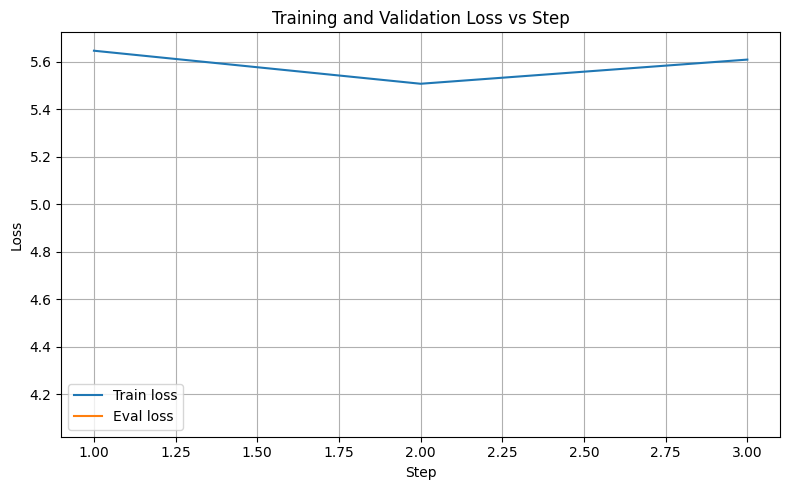

Saved epoch-based loss curve to: /content/drive/MyDrive/processed data/sample_decoder_plots/loss_vs_epoch.png


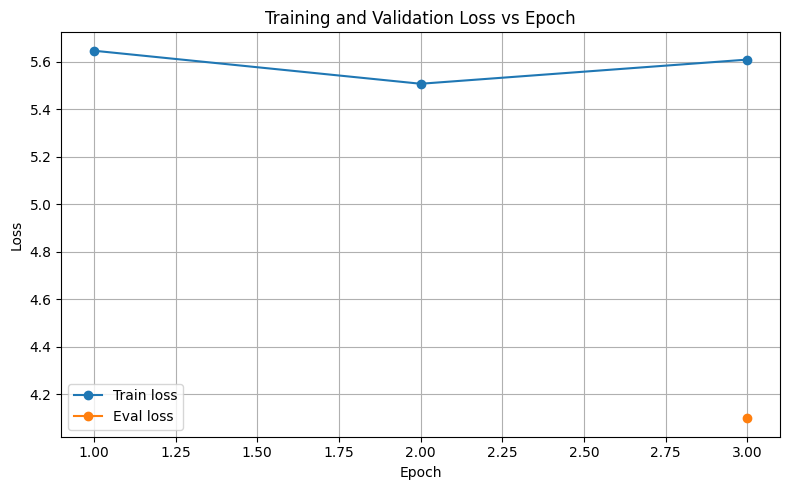

Saved perplexity curve to: /content/drive/MyDrive/processed data/sample_decoder_plots/perplexity_vs_epoch.png


<Figure size 640x480 with 0 Axes>

In [ ]:
eval_results = trainer.evaluate()

if "eval_loss" in eval_results:
    overall_perplexity = math.exp(eval_results["eval_loss"])
    print("Validation Perplexity (overall):", overall_perplexity)
else:
    print("No eval_loss found in eval_results.")

epoch_train_losses = defaultdict(list)
epoch_eval_losses  = defaultdict(list)
epoch_eval_ppls    = defaultdict(list)

for entry in trainer.state.log_history:
    # Training loss entries
    if "loss" in entry and "epoch" in entry and "eval_loss" not in entry:
        epoch_train_losses[entry["epoch"]].append(entry["loss"])
    # Evaluation loss entries
    if "eval_loss" in entry and "epoch" in entry:
        epoch_eval_losses[entry["epoch"]].append(entry["eval_loss"])
        try:
            epoch_eval_ppls[entry["epoch"]].append(math.exp(entry["eval_loss"]))
        except OverflowError:
            epoch_eval_ppls[entry["epoch"]].append(float("inf"))

print("\nEpoch | Train loss | Eval loss | Val Perplexity")
print("------|-----------|-----------|----------------")

rows = []
all_epochs = sorted(set(list(epoch_train_losses.keys()) + list(epoch_eval_losses.keys())))
for ep in all_epochs:
    train_loss = epoch_train_losses[ep][-1] if ep in epoch_train_losses else None
    eval_loss  = epoch_eval_losses[ep][-1]  if ep in epoch_eval_losses  else None
    val_ppl    = epoch_eval_ppls[ep][-1]    if ep in epoch_eval_ppls    else None

    t_str = f"{train_loss:.4f}" if train_loss is not None else "   -   "
    e_str = f"{eval_loss:.4f}"  if eval_loss  is not None else "   -   "
    p_str = f"{val_ppl:.2f}"    if val_ppl    is not None else "   -   "

    print(f"{ep:5.1f} | {t_str:9} | {e_str:9} | {p_str:14}")

    rows.append({
        "epoch": ep,
        "train_loss": train_loss,
        "eval_loss": eval_loss,
        "val_perplexity": val_ppl,
    })

epoch_df = pd.DataFrame(rows).sort_values("epoch")
print("\nEpoch summary DataFrame:")
display(epoch_df)

log_df = pd.DataFrame(trainer.state.log_history)
print("\nLog history columns:", log_df.columns.tolist())
display(log_df.head())

# Prepare plot directory based on whether we're using sample or full data

plot_dir_name = "sample_decoder_plots" if USE_SAMPLE_DATA else "full_decoder_plots"
PLOT_DIR = os.path.join(BASE_DIR, plot_dir_name)
os.makedirs(PLOT_DIR, exist_ok=True)
print("Saving plots to:", PLOT_DIR)

# Train & eval loss vs step plot

train_log = log_df[log_df["loss"].notna()][["step", "epoch", "loss"]].copy()
eval_log  = log_df[log_df["eval_loss"].notna()][["step", "epoch", "eval_loss"]].copy()

plt.figure(figsize=(8, 5))
if not train_log.empty:
    plt.plot(train_log["step"], train_log["loss"], label="Train loss")
if not eval_log.empty:
    plt.plot(eval_log["step"], eval_log["eval_loss"], label="Eval loss")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss vs Step")
plt.legend()
plt.grid(True)
plt.tight_layout()

step_curve_path = os.path.join(PLOT_DIR, "loss_vs_step.png")
plt.savefig(step_curve_path)
print("Saved step-based loss curve to:", step_curve_path)

plt.show()

# Loss vs epoch plot

if not epoch_df.empty:
    plt.figure(figsize=(8, 5))
    if epoch_df["train_loss"].notna().any():
        plt.plot(epoch_df["epoch"], epoch_df["train_loss"], marker="o", label="Train loss")
    if epoch_df["eval_loss"].notna().any():
        plt.plot(epoch_df["epoch"], epoch_df["eval_loss"], marker="o", label="Eval loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss vs Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    epoch_curve_path = os.path.join(PLOT_DIR, "loss_vs_epoch.png")
    plt.savefig(epoch_curve_path)
    print("Saved epoch-based loss curve to:", epoch_curve_path)

    plt.show()


  #Saving Plots
ppl_curve_path = os.path.join(PLOT_DIR, "perplexity_vs_epoch.png")
plt.savefig(ppl_curve_path)
print("Saved perplexity curve to:", ppl_curve_path)

plt.show()



## Text Decoder (GPT-2) Design and Training

For the report generation component, I used **GPT-2** as a causal language model that acts purely as a text decoder. Rather than feeding raw reports, I created a structured target sequence for each example that concatenates the two clinically important sections.

To make this explicit, I format each training report as:

```text
<BOS> <FINDINGS> [findings_final] <IMPRESSION> [impression_final] <EOS>
